# Qiskit for Finance

Qiskit already provides some of the code we needed to handcraft within its package for finance. We will see hoow already seen methods can be used by simply invoking this functionalities from the package.

In [16]:
import json
import numpy as np
from qiskit_finance.applications.optimization import PortfolioOptimization


data = None
n = input("Enter the number of symbols to crawl: ")
jsonfilename = f"{n}asset.json"
with open(jsonfilename, "r") as jsonfile:
    data = json.load(jsonfile)
returns = data['mu']
covar = data['sigma']

assets = []
costs = []
for row in data['assets']:
    assets.append(row["Asset"])
    costs.append(float(row["Open"]))

num_assets = len(assets)

#set up
q = 0.5  # set risk factor
budget = len(assets) // 2  # set budget

portfolio = PortfolioOptimization(
    expected_returns=returns, covariances=covar, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00023404169371090647*x_0^2 + 0.00042506199158582..., 4 variables, 1 constraints, 'Portfolio optimization'>

Now we should set our budget and the risk so that que quadrativ program can be instantiated.

In [28]:
#exact_eigensolver
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
import time
import csv
import pickle
import pandas as pd
import sys
import os

# Load the DataFrame from a file if it exists
if os.path.isfile('numpy.pkl'):
    df = pd.read_pickle('numpy.pkl')
else:
    df = pd.DataFrame(columns=['Num_Symbols', 'numpy_val_list'])

numpyselection = f"{n}assetnumpy.csv"
numpy_val_list = []  

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)
print(result)
# Extract the optimal solution
optimal_solution = result.x

# Convert the solution to a list
val_list = optimal_solution.tolist()

print(type(val_list))

with open('numpy.pkl', 'wb') as f:
    pickle.dump(numpy_val_list, f)
with open('numpy.pkl', 'rb') as f:
    val_list = pickle.load(f)


# Create a new DataFrame with a single row
new_row = pd.DataFrame({'Num_Symbols': n , 'numpy_val_list': [val_list]})
print(type(new_row))
# Append the new row to the existing DataFrame
df = pd.concat([df, new_row], ignore_index=True)

# Save the DataFrame to a file
df.to_pickle('numpy.pkl')

print(df)


fval=-0.000454335451833828, x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, status=SUCCESS
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_74429/1980180393.py:21: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  exact_mes = NumPyMinimumEigensolver()


TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

We can check the selection still holds to the original solution we had for the classical and annealing procedures. Now we will see how it works when solving this very same problem using already mentioned QAOA and VQE algorithms.

When dealing with Variation Quantum Algorithms two main things need to be selected:

* Optimization procedure to be used
* Circuit

In nex example COBYLA and a TwoLocal implementation will be used. The TwoLocal circuit can hold several repetitions of the same scheme containing different operations arbitratily chosen.

In [4]:
#COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit import Aer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals

ansatz = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
ansatz.decompose().draw('mpl', fold=150)

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)

quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
vqe_mes = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)
import csv
import pandas as pd
vqeselection = f"{n}assetvqe.csv"
with open(vqeselection, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Asset", "Selected"])

    for i, val in enumerate(np.round(result.x,1)):
        if val == 1:
            writer.writerow([assets[i], 1])
        else:
            writer.writerow([assets[i], 0])

/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_69999/3105675477.py:18: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_69999/3105675477.py:19: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe_mes = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)
Note: Using a statevector_simulator with 16 qubits can be very expensive. Consider u

: 

$\theta$ parameters for this circuit are the ones that need to be trained so that at the end, the solution with highest success probability shows the result to our problem.

At this point it is important we pay attention at the probability column. This column states how plausible it is that using this circuit with found parameters we may found the optimal result. Our candidate solution has relativelly low probability, which means we should find better designs to increase our chances. We can easilly test how it would look like by adding more repetitions to the ansatz.

Right now we reached 20% chances of seeing this state on a single run of our circuit. We could then simulate lets say for 5 runs so that way we most probably would register classically that state at least once.

In [61]:
best_parameters = None
for key, value in vqe_mes.__dict__.items():
    if key == "_ret":
        best_parameters = value.optimal_parameters

We can try with a different approach, in this case QAOA. For that, only number of layers to repeat the canonical form of the ansatz need to be provided.

In [62]:
from qiskit.algorithms import QAOA

layers = 2
qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)
qaoaselection = f"{n}assetqaoa.csv"
with open(qaoaselection, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Asset", "Selected"])

    for i, val in enumerate(np.round(result.x,1)):
        if val == 1:
            writer.writerow([assets[i], 1])
        else:
            writer.writerow([assets[i], 0])

/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_57286/647241148.py:4: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)


In this case, the depth of the circuit did not make much in favor of our outcome as the chances of getting the optimal solution decreased from almost 8% to 6%.

As it also happends with classical ML and QML approaches, design is key for solving the problem with a high success rate for obtaining the best possible solution. Lets run our best solution up to now and see how the outcome would look like.

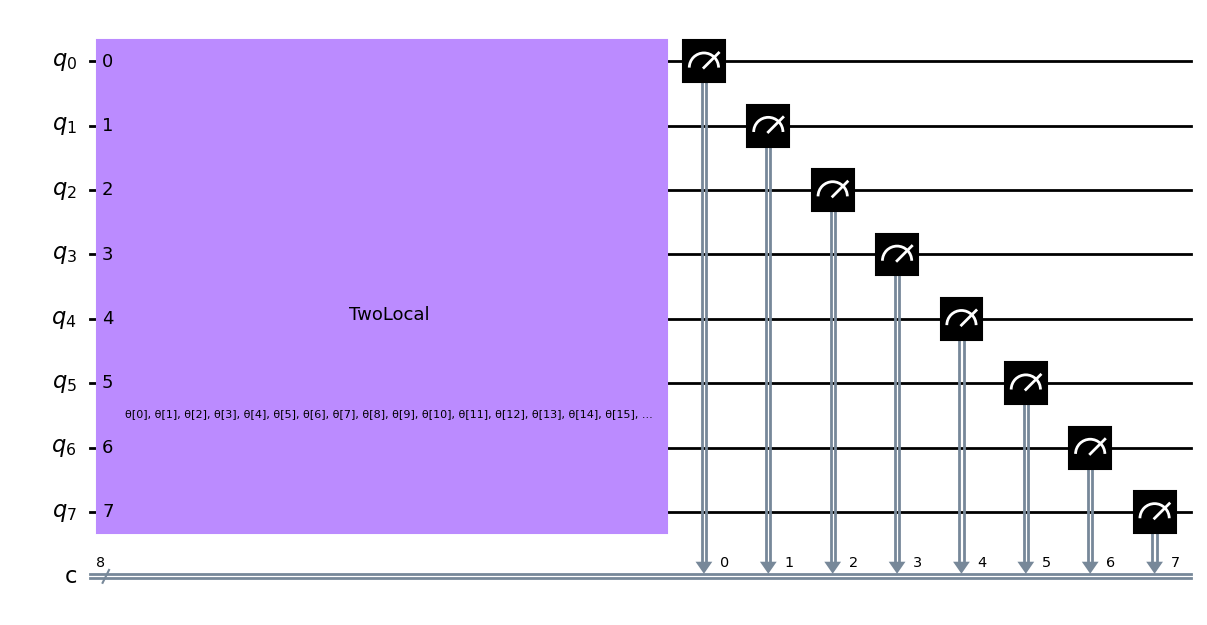

In [63]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(num_assets,num_assets)

# VQE Two Local ansatz
qc.compose(ansatz, inplace=True)

# Measures
for i in range(0, num_assets):
    qc.measure(i, i)

qc.draw('mpl', fold=150)

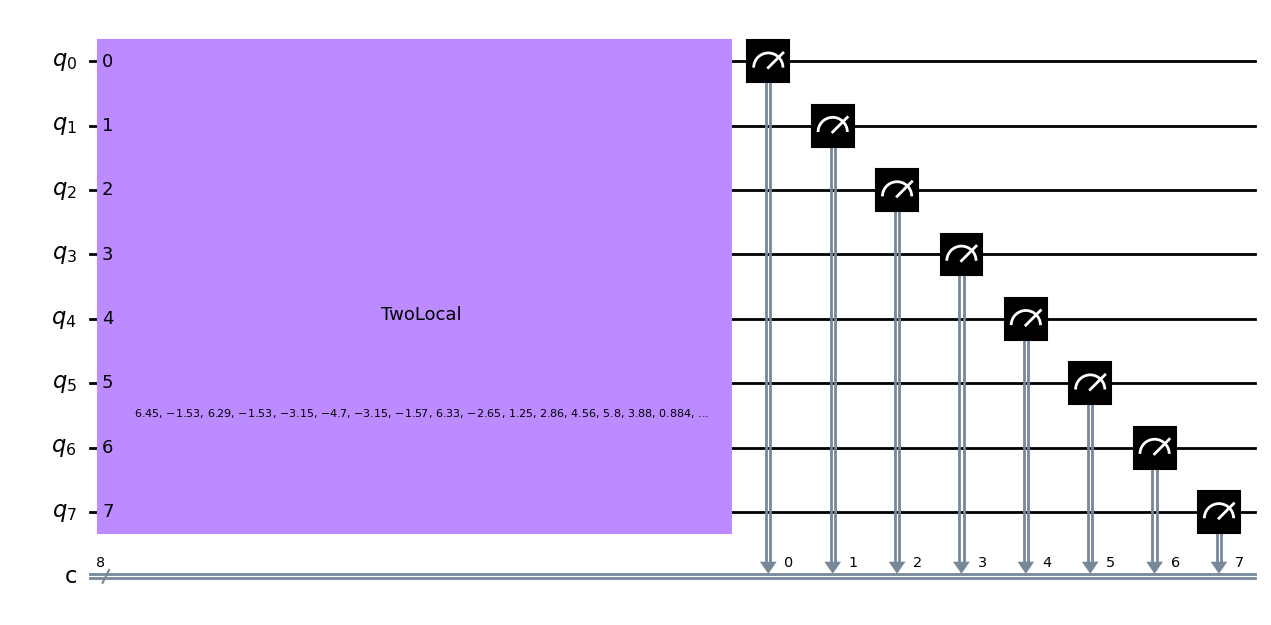

In [64]:
pqc = qc.bind_parameters(best_parameters)
pqc.draw('mpl', fold=150)

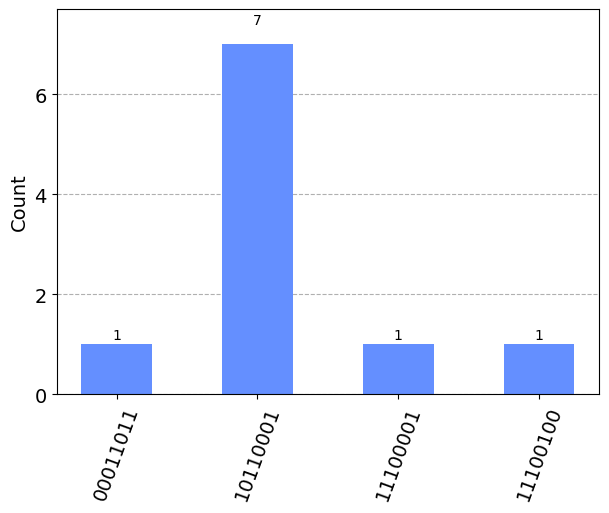

In [65]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

# Number of shots to the circuit
nshots = 10

# execute the quantum circuit
backend = Aer.get_backend('qasm_simulator') # the device to run on
result = execute(pqc, backend, shots=nshots).result()
counts  = result.get_counts(pqc)

plot_histogram(counts)

In [66]:
print("Solutions found:")
for cres in counts:
    print(f"Solution {cres[::-1]} with success probability {counts[cres]*100/nshots}%")

Solutions found:
Solution 11011000 with success probability 10.0%
Solution 10000111 with success probability 10.0%
Solution 00100111 with success probability 10.0%
Solution 10001101 with success probability 70.0%
